In [1]:
import configparser
import glob
from pyspark.sql.window import Window
import pandas as pd
import test
from pyspark.sql import SparkSession
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
from tqdm import tqdm
'''
START UP SCRIPT

run this before any other cell

sets up relative path structure and starts Spark used for preprocessing as well as imports some common modules
'''

#start the spark session
sc = SparkSession.builder.master("local").appName("stan_eval").getOrCreate()

ugr16_column_name = 'te', 'td', 'sa', 'da', 'sp', 'dp', 'pr', 'flg', 'fwd', 'stos', 'pkt', 'byt', 'label'
stan_column_name = 'teT', 'teDelta', 'log_byt', 'log_pkt', 'td', 'sa', 'da', 'sp', 'dp', 'pr'
synth_column_name = 'order', 'hour', 'time_delta', 'byt', 'pkt', 'time_duration', 'sp', 'dp', 'sa', 'da', 'pr'

stats_data_types = {'seconds': np.float32, 'byt': np.float32, 'pkt': np.float32, 'time_duration': np.float32,
                    'time_delta': np.float32, 'sp': np.int32, 'dp': np.int32}

rules_data_types = {'byt': np.float32, 'pkt': np.float32, 'td': np.float32,
                    'sp': np.int32, 'dp': np.int32}

config = configparser.ConfigParser()
config.read('ugr16_config.ini')
user_list = config['DEFAULT']['userlist'].split(',')

data_path = '/home/ubuntu/Documents/data/'  #linux path for all data files that the models access and write too
stan_path = data_path + 'stan/' # path for the model to save checkpoints and various stages for preprocessing

part_path_day1 = stan_path + 'partitioned_data/day_1/without_attacks'  #path to data partitioned into IPs
part_path_day2 = stan_path + 'partitioned_data/day_2/'  #path to data partitioned into IPs
real_path = data_path + 'ugr16/'  #path to source data files
rslt_path = data_path + 'results/'

raw_file_day1 = real_path + 'april_week3_day1.csv'  #source ugr16 file for day1 used for training
raw_file_day2 = real_path + 'april_week3_day2.csv'  #source ugr16 file

pre_file = stan_path + 'preprocessed_data/april_week3_day1_PREPROCESSED.csv'  #output fully preprocessed file

snth_path = stan_path + 'synthesized_data/'

sngl_rslt_path = rslt_path + 'single_sample/' #path for metrics which only looks at the data of a single asset
full_rslt_path = rslt_path + 'full_sample/' #path for metrics considering 100 assets
grph_rslt_path = rslt_path + 'stats_graphs/' #location for images of figures to be saved

test_path = data_path + 'test_data/'

real_tst_day1_file = test_path + 'real_april_day1.csv' #real data used for training
real_tst_day2_file = test_path + 'real_april_day2.csv' #real data used for testing
snth_tst_file = test_path + 'snth_april_day1_epoch%d.csv'
divg_file = rslt_path + 'divergence.csv'



bash: switchml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `switchml'
bash: _moduleraw: line 1: syntax error: unexpected end of file
bash: error importing function definition for `_moduleraw'
bash: _moduleraw: line 1: syntax error: unexpected end of file
bash: error importing function definition for `_moduleraw'
bash: switchml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `switchml'
22/08/02 00:27:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
#ensure all folders are in place and usable
Path(data_path).mkdir(parents=True, exist_ok=True)
Path(stan_path).mkdir(parents=True, exist_ok=True)
Path(part_path_day1).mkdir(parents=True, exist_ok=True)
Path(part_path_day2).mkdir(parents=True, exist_ok=True)
Path(real_path).mkdir(parents=True, exist_ok=True)
Path(rslt_path).mkdir(parents=True, exist_ok=True)
Path(snth_path).mkdir(parents=True, exist_ok=True)
Path(sngl_rslt_path).mkdir(parents=True, exist_ok=True)
Path(full_rslt_path).mkdir(parents=True, exist_ok=True)
Path(grph_rslt_path).mkdir(parents=True, exist_ok=True)
Path(test_path).mkdir(parents=True, exist_ok=True)

In [5]:
from pyspark.sql.functions import log, split, when, array_contains, lag, isnull, floor
'''
PREPROCESSING START

function definition for ingesting UGR data

pulls all of the real data into spark data frame
grouped by user then time difference between entries is calculated

then STAN preprocessing takes over creating windows for all the users concatenated into a single file
'''
def partition_ugr_data(source_file=raw_file_day1, dest_path=part_path_day1):
    local_ip = '42.219'
    stan_window = Window.partitionBy('local_ip').orderBy("seconds")


    df_raw = sc.read.csv(source_file)
    df_raw = df_raw.toDF(*ugr16_column_name)

    df_working = df_raw.withColumn('log_byt', log(df_raw.byt))
    df_working = df_working.withColumn('log_pkt', log(df_working.pkt))

    # pull minutes hours and seconds from timestamp into a single number
    df_working = df_working.withColumn('time_text', split(df_working.te, " ").getItem(1))

    df_working = df_working.withColumn('seconds',
                                       split(df_working.time_text, ':')[0] * 3600 +
                                       split(df_working.time_text, ':')[1] * 60 +
                                       split(df_working.time_text, ':')[2])

    df_working = df_working.withColumn('local_ip',
                                       when(df_working.sa.startswith(local_ip), df_working.sa)
                                       .when(df_working.da.startswith(local_ip), df_working.da)
                                       .otherwise(0))

    df_working = df_working.where(df_working.local_ip.isin(user_list))
    df_working = df_working.where(df_working.label == 'background')


    df_working = df_working.withColumn('prev_seconds', lag(df_working.seconds).over(stan_window))

    df_working = df_working.withColumn('teDelta',
                                       when(isnull(df_working.seconds - df_working.prev_seconds), 0)
                                       .otherwise(df_working.seconds - df_working.prev_seconds))

    df_out = df_working.select('seconds', 'teDelta', 'log_byt', 'byt', 'log_pkt', 'pkt', 'td', 'sa', 'da', 'sp', 'dp', 'pr',
                               'local_ip')

    df_out = df_out.withColumn("this_ip", df_out.local_ip)
    df_out = df_out.withColumn("teT", floor((df_out.seconds / 3600)))

    df_out.write.option('header', True).mode("overwrite").partitionBy("local_ip").csv(dest_path)

Call the ingest function for both days of data which are used

In [ ]:
partition_ugr_data(source_file=raw_file_day1, dest_path=part_path_day1)

In [6]:
partition_ugr_data(source_file=raw_file_day2, dest_path=part_path_day2)

Runs stan preprocessing,
input data is at the path to real data partitioned by local IP
prints windowed output to preprocessing file

In [6]:
from stannetflow import preprocess as p

p.prepare_standata(train_folder=part_path_day1, train_output=pre_file)
print("------------------FINSIHED------------------")

user: 42.219.153.71
user: 42.219.153.193
user: 42.219.154.152
user: 42.219.153.81
user: 42.219.153.187
user: 42.219.145.151
user: 42.219.155.123
user: 42.219.153.146
user: 42.219.154.18
user: 42.219.154.134
user: 42.219.153.198
user: 42.219.158.251
user: 42.219.153.159
user: 42.219.153.241
user: 42.219.157.246
user: 42.219.153.190
user: 42.219.158.231
user: 42.219.153.165
user: 42.219.158.209
user: 42.219.154.124
user: 42.219.153.47
user: 42.219.153.82
user: 42.219.153.59
user: 42.219.152.238
user: 42.219.153.154
user: 42.219.158.162
user: 42.219.156.194
user: 42.219.153.9
user: 42.219.155.25
user: 42.219.155.115
user: 42.219.152.246
user: 42.219.152.127
user: 42.219.159.219
user: 42.219.153.75
user: 42.219.159.188
user: 42.219.159.170
user: 42.219.153.216
user: 42.219.153.113
user: 42.219.155.89
user: 42.219.154.184
user: 42.219.153.80
user: 42.219.153.45
user: 42.219.158.224
user: 42.219.155.72
user: 42.219.153.5
user: 42.219.155.86
user: 42.219.153.35
user: 42.219.155.30
user: 42.21

In [2]:
'''
call to train the model to the given epoch then generate data for the final epoch

The method should have it's own documentation but I will add a short description here
The model will be trained on the windwed-preprocesed data located at 'pre_file'
if checkpoint is higher than 0 it will try to load the specified checkpoint
when the model is trained to 'epochs' it will generate samples for each user in this_ip
since this_ip is not specified here no data will be generated
when data is generated the version of the model currently in memory is used
This will either be the checkpoint loaded or the version of the model that was being trained
the synthesised data is saved to snth_path but the root stan_path is passed to the function
'''
df = test.test_ugr16(pre_file, checkpoint=0, epochs=900, sample_duration=86400,
                     data_path=stan_path)


starting epoch 0
starting epoch 1
starting epoch 2
starting epoch 3
starting epoch 4
starting epoch 5
starting epoch 6
starting epoch 7
starting epoch 8
starting epoch 9
starting epoch 10
starting epoch 11
starting epoch 12
starting epoch 13
starting epoch 14
starting epoch 15
starting epoch 16
starting epoch 17
starting epoch 18
starting epoch 19
starting epoch 20
starting epoch 21
starting epoch 22
starting epoch 23
starting epoch 24
starting epoch 25
starting epoch 26
starting epoch 27
starting epoch 28
starting epoch 29
starting epoch 30
starting epoch 31
starting epoch 32
starting epoch 33
starting epoch 34
starting epoch 35
starting epoch 36
starting epoch 37
starting epoch 38
starting epoch 39
starting epoch 40
starting epoch 41
starting epoch 42
starting epoch 43
starting epoch 44
starting epoch 45
starting epoch 46
starting epoch 47
starting epoch 48
starting epoch 49
starting epoch 50
starting epoch 51


ValueError: Expected parameter loc (Tensor of shape (512, 10, 1)) of distribution Normal(loc: torch.Size([512, 10, 1]), scale: torch.Size([512, 10, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        ...,

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]], device='cuda:0', grad_fn=<TransposeBackward0>)

In [9]:
'''
read preprocessed ugr data into a single file

used primarily metrics to more easily compare synthetic data to real
'''
open(real_tst_day2_file, mode='w').write('')
first_file = True
for f in glob.glob(part_path_day2 + '**/*.csv'):
    if first_file:
        first_file = False
        pd.read_csv(f).to_csv(real_tst_day2_file, mode='w')
    else:
        pd.read_csv(f).to_csv(real_tst_day2_file, mode='a', header=False)


In [ ]:
#test cell
pd.read_csv(part_path_day1).sort_values(by='seconds')

In [5]:
'''
GENERATE SNYTHETIC DATA

calls the test method to generate single samples for all specified
'''
for epoch in range(85, 400, 5):
    crnt_path = snth_path + 'epoch_%s/' % epoch
    Path(crnt_path).mkdir(parents=True, exist_ok=True)

    df_t = test.test_ugr16(pre_file, checkpoint=epoch, epochs=epoch, this_ip=user_list[0], model_path=stan_path,
                           save_path=crnt_path)


/home/ubuntu/Documents/data/stan/synthesized_data/epoch_85/
loading model at epoch: 85
<class 'str'>
/home/ubuntu/Documents/data/stan/synthesized_data/epoch_90/
loading model at epoch: 90
<class 'str'>
/home/ubuntu/Documents/data/stan/synthesized_data/epoch_95/
loading model at epoch: 95
<class 'str'>
/home/ubuntu/Documents/data/stan/synthesized_data/epoch_100/
loading model at epoch: 100
<class 'str'>
/home/ubuntu/Documents/data/stan/synthesized_data/epoch_105/
loading model at epoch: 105
<class 'str'>
/home/ubuntu/Documents/data/stan/synthesized_data/epoch_110/
loading model at epoch: 110
<class 'str'>
/home/ubuntu/Documents/data/stan/synthesized_data/epoch_115/
loading model at epoch: 115
<class 'str'>
/home/ubuntu/Documents/data/stan/synthesized_data/epoch_120/
loading model at epoch: 120
<class 'str'>
/home/ubuntu/Documents/data/stan/synthesized_data/epoch_125/
loading model at epoch: 125
<class 'str'>
/home/ubuntu/Documents/data/stan/synthesized_data/epoch_130/
loading model at e

In [ ]:
#generate data for 100 asset list then concatenate the data into a single file reordered by time


synth_window = Window.partitionBy('hour').orderBy("order").rangeBetween(Window.unboundedPreceding, 0)

for epoch in range(395, 400, 5):
    crnt_path = snth_path + 'epoch_%s/' % epoch
    Path(crnt_path).mkdir(parents=True, exist_ok=True)
    print(crnt_path)

    test.test_ugr16(pre_file, checkpoint=epoch, epochs=epoch, this_ip=user_list, model_path=stan_path,
                    save_path=crnt_path)

    ls_synth = []
    first = True

    for f in tqdm(glob.glob(crnt_path + '*.csv')):
    # READING AS SPARK df
    # df_t = sc.read.options(header=True, index=False).csv(f)
    # df_t = df_t.toDF(*synth_column_name)
    #
    # df_t = df_t.withColumn('seconds', ps_sum(df_t.time_delta).over(synth_window))
        df_t = pd.read_csv(f, index_col=0)
        df_t['seconds'] = df_t['time_delta'].cumsum()

        ls_synth.append(df_t)

    # for e in ls_synth:
    #     if first:
    #         df_synth = e
    #         first = False
    #     else:
    #         df_synth = df_synth.union(e)

    df_synth = pd.concat(ls_synth)
    df_synth.sort_values(by=['seconds'])
    display(df_synth)

    df_synth.to_csv(test_path + 'snth_april_day1_epoch%d.csv' % epoch)

/home/ubuntu/Documents/data/stan/synthesized_data/epoch_395/


In [19]:
#run analysis on aggregated synthetic data
import csv
from os.path import exists
import numpy as np
from stannetflow.evaluation.metric_runner import see_f_dist_df

df_d1_test = pd.read_csv(real_tst_day1_file, index_col=0)
df_d1_test.rename(columns={'teDelta': 'time_delta', 'td': 'time_duration', 'teT': 'hour'}, inplace=True)
df_d1_test = df_d1_test[['hour', 'seconds', 'time_delta', 'byt', 'pkt', 'time_duration', 'sa', 'da', 'sp', 'dp', 'pr']]

df_d1_test = df_d1_test.astype(stats_data_types)
first = True

for epoch in tqdm(range(0, 400, 5)):
    try:
        df_sn_test = pd.read_csv(snth_tst_file % epoch, index_col=0)
    except FileNotFoundError:
        continue

    df_sn_test = df_sn_test[
        ['hour', 'seconds', 'time_delta', 'byt', 'pkt', 'time_duration', 'sa', 'da', 'sp', 'dp', 'pr']]
    df_d1_test = df_d1_test.astype(stats_data_types)

    real_stats, snth_stats = see_f_dist_df(df_d1_test, df_sn_test, snth_name='epoch%d' % epoch)

    if first:
        first = False

        for stat in real_stats:
            if type(real_stats[stat]) is dict:
                with open(full_rslt_path + '%s.csv' % stat, mode='w') as f:
                    wr = csv.writer(f)

                    wr.writerow(['name'] + list(real_stats[stat]))  #write label
                    wr.writerow([real_stats['name']] + list(real_stats[stat].values()))  #write real stat values

    for stat in snth_stats:
        if type(snth_stats[stat]) is dict:
            with open(full_rslt_path + '%s.csv' % stat, mode='a') as f:
                wr = csv.writer(f)

                wr.writerow([snth_stats['name']] + list(snth_stats[stat].values()))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [28:02<00:00, 21.03s/it]


<Figure size 432x288 with 0 Axes>

In [3]:
df_d1_test.agg({'teDelta': 'max', 'log_byt': 'max', 'log_pkt': 'max', 'td': 'max'}).show()

KeyError: "Column(s) ['td', 'teDelta'] do not exist"

In [20]:
#run analysis on first asset of each epoch
import csv
from stannetflow.evaluation.metric_runner import see_f_dist_df
from pyspark.sql.functions import sum as ps_sum

#after being processed in earlier  cells the real data should have a column containing the second the flow started


synth_window = Window.orderBy("order").rangeBetween(Window.unboundedPreceding, 0)

df_d1_test = pd.read_csv(part_path_day1 + 'local_ip=42.219.145.151/part-00003-34579832-af80-4406-a6e0-a1a82778d731.c000.csv',
                         index_col=False)
df_d1_test.rename(columns={'teDelta': 'time_delta', 'td': 'time_duration', 'teT': 'hour'}, inplace=True)
df_d1_test = df_d1_test[['hour', 'seconds', 'time_delta', 'byt', 'pkt', 'time_duration', 'sa', 'da', 'sp', 'dp', 'pr']]
df_d1_test = df_d1_test.astype(stats_data_types)

first = True

for epoch in range(0, 400, 5):
    df_synth = sc.read.options(header=True, index=False).csv(snth_path + 'epoch_%d/42.219.145.151.csv' % epoch)
    df_synth = df_synth.toDF(*synth_column_name)

    df_synth = df_synth.withColumn('seconds', ps_sum(df_synth.time_delta).over(synth_window))
    df_synth.printSchema()
    df_synth = df_synth.drop("order")
    df_synth = df_synth.orderBy(df_synth.seconds)

    df_sn_test = df_synth.toPandas()

    df_sn_test = df_sn_test.astype(stats_data_types)
    print(df_sn_test)

    df_sn_test = df_sn_test[
        ['hour', 'seconds', 'time_delta', 'byt', 'pkt', 'time_duration', 'sa', 'da', 'sp', 'dp', 'pr']]

    real_stats, snth_stats = see_f_dist_df(df_d1_test, df_sn_test, snth_name='epoch%d' % epoch)

    if first:
        first = False

        for stat in real_stats:
            if type(real_stats[stat]) is dict:
                with open(sngl_rslt_path + '%s.csv' % stat, mode='w') as f:
                    wr = csv.writer(f)

                    wr.writerow(['name'] + list(real_stats[stat]))  #write label
                    wr.writerow([real_stats['name']] + list(real_stats[stat].values()))  #write real stat values

    for stat in snth_stats:
        if type(snth_stats[stat]) is dict:
            with open(sngl_rslt_path + '%s.csv' % stat, mode='a') as f:
                wr = csv.writer(f)

                wr.writerow([snth_stats['name']] + list(snth_stats[stat].values()))

KeyboardInterrupt: 

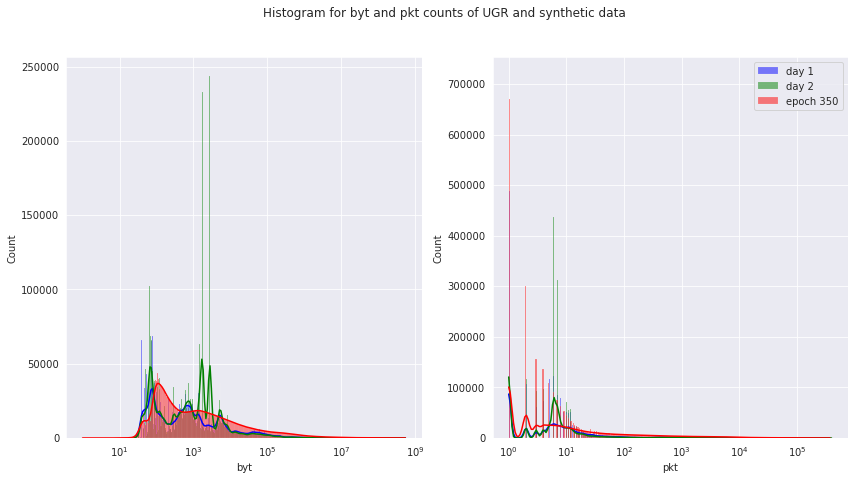

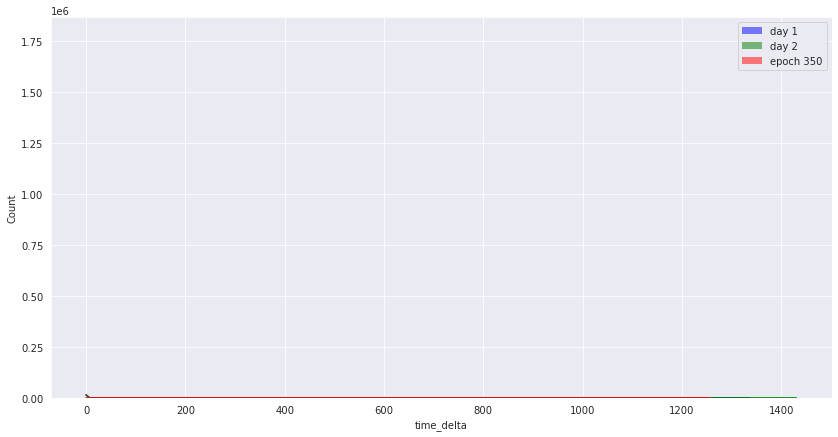

In [48]:

df_d1_test = pd.read_csv(real_tst_day1_file, index_col=0)
df_d1_test.rename(columns={'teDelta': 'time_delta', 'td': 'time_duration', 'teT': 'hour'}, inplace=True)
df_d1_test = df_d1_test[['hour', 'seconds', 'time_delta', 'byt', 'pkt', 'time_duration', 'sa', 'da', 'sp', 'dp', 'pr']]
df_d1_test['type'] = df_d1_test.apply(lambda x: 'real', axis=1)


df_d2_test = pd.read_csv(real_tst_day2_file, index_col=0)
df_d2_test.rename(columns={'teDelta': 'time_delta', 'td': 'time_duration', 'teT': 'hour'}, inplace=True)
df_d2_test = df_d2_test[['hour', 'seconds', 'time_delta', 'byt', 'pkt', 'time_duration', 'sa', 'da', 'sp', 'dp', 'pr']]
df_d2_test['type'] = df_d2_test.apply(lambda x: 'real', axis=1)


df_sn_test = pd.read_csv(snth_tst_file % 350, index_col=0)
df_sn_test = df_sn_test[
    ['hour', 'seconds', 'time_delta', 'byt', 'pkt', 'time_duration', 'sa', 'da', 'sp', 'dp', 'pr']]
df_sn_test = df_sn_test.astype(stats_data_types)
df_sn_test['type'] = df_sn_test.apply(lambda x: 'synthetic', axis=1)

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("Histogram for byt and pkt counts of UGR and synthetic data")

sns.histplot(df_d1_test['byt'], ax=ax[0], log_scale=10, color="blue", kde=True, legend=True, label='day 1')
sns.histplot(df_d2_test['byt'], ax=ax[0], log_scale=10, color="green", kde=True, legend=True, label='day 2')
sns.histplot(df_sn_test['byt'], ax=ax[0], log_scale=10, color="red", kde=True, legend=True, label='epoch 350')


sns.histplot(df_d1_test['pkt'], ax=ax[1], log_scale=10, color="blue", kde=True, legend=True, label='day 1')
sns.histplot(df_d2_test['pkt'], ax=ax[1], log_scale=10, color="green", kde=True, legend=True, label='day 2')
sns.histplot(df_sn_test['pkt'], ax=ax[1], log_scale=10, color="red", kde=True, legend=True, label='epoch 350')

plt.legend()
fig.savefig(grph_rslt_path + 'full_sample/distribution_byt_pkt.png')

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

sns.histplot(df_d1_test['time_delta'], ax=ax, color="blue", kde=True, legend=True, label='day 1')
sns.histplot(df_d2_test['time_delta'], ax=ax, color="green", kde=True, legend=True, label='day 2')
sns.histplot(df_sn_test['time_delta'], ax=ax, color="red", kde=True, legend=True, label='epoch 350')
plt.legend()

,name,byt,pkt,time_delta,time_duration,sp,dp,pr,byt_real,pkt_real,time_delta_real,time_duration_real
0,real,2.185657,1.372881,18.469201,49.490527,24528.540140,24025.870873,0.507169,2.185657,1.372881,18.469201,49.490527
1,epoch0,5.662066,3.570666,377.354199,28.477140,19740.088848,19805.229219,0.818825,2.185657,1.372881,18.469201,49.490527
2,epoch5,2.338492,2.026712,39.880083,11.315039,27260.641522,29322.595095,0.733493,2.185657,1.372881,18.469201,49.490527
3,epoch10,1.714875,1.273877,138.728553,8.661777,26662.079103,29458.265607,0.681586,2.185657,1.372881,18.469201,49.490527
4,epoch15,3.644920,2.983735,423.080014,20.458661,21349.774875,24111.992335,0.496055,2.185657,1.372881,18.469201,49.490527
5,epoch20,2.555934,2.136466,295.158584,16.121815,23443.415388,26392.500378,0.715620,2.185657,1.372881,18.469201,49.490527
6,epoch25,2.889998,1.770931,395.926246,24.758046,19269.957755,29630.592174,0.530906,2.185657,1.372881,18.469201,49.490527
7,epoch30,3.418054,2.240379,321.805844,27.284713,27784.510836,30570.121609,0.571607,2.185657,1.372881,18.469201,49.490527
8,epoch35,3.830275,3.035661,384.227024,28.950474,19357.901240,22835.705174,0.583392,2.185657,1.372881,18.469201,49.490527
9,epoch40,3.318372,2.340934,390.047295,24.544223,18933.933097,25177.099383,0.553914,2.185657,1.372881,18.469201,49.490527


,name,byt,pkt,time_delta,time_duration,sp,dp,pr,byt_real,pkt_real,time_delta_real,time_duration_real
0,real,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,epoch0,1.363984,0.928322,3.806645,3.026767,0.758157,0.774100,0.476615,0.0,0.0,0.0,0.0
2,epoch5,1.571998,1.951927,1.704652,1.627826,0.804981,0.622457,0.868249,0.0,0.0,0.0,0.0
3,epoch10,1.627809,2.982796,2.264877,1.832236,0.956494,0.891957,0.717485,0.0,0.0,0.0,0.0
4,epoch15,0.771835,1.980946,0.791604,3.278314,1.835798,1.781959,1.139570,0.0,0.0,0.0,0.0
5,epoch20,0.948035,2.218153,0.588506,1.087925,1.144765,1.009808,1.073109,0.0,0.0,0.0,0.0
6,epoch25,0.695167,2.760977,0.786177,2.452449,2.179090,1.998139,0.638522,0.0,0.0,0.0,0.0
7,epoch30,0.566866,2.168069,0.475369,2.724748,1.511829,1.287984,0.501421,0.0,0.0,0.0,0.0
8,epoch35,0.619264,1.873318,0.776360,1.739287,1.543613,1.511320,1.322814,0.0,0.0,0.0,0.0
9,epoch40,0.745938,2.317405,0.918244,1.881116,1.656210,1.571108,1.236691,0.0,0.0,0.0,0.0


,name,byt,pkt,time_delta,time_duration,sp,dp,pr,byt_real,pkt_real,time_delta_real,time_duration_real
0,real,6.531399,2.001154,5.036760,12.844671,22137.269002,19092.739510,0.277704,6.531399,2.001154,5.03676,12.844671
1,epoch0,9.167329,5.877745,607.561102,45.720698,13108.083176,13290.438055,1.009304,6.531399,2.001154,5.03676,12.844671
2,epoch5,6.525808,2.013589,38.762731,7.313574,19477.161558,28819.520980,0.794968,6.531399,2.001154,5.03676,12.844671
3,epoch10,5.589725,1.426812,97.076206,4.752690,19282.523449,33330.531131,0.784984,6.531399,2.001154,5.03676,12.844671
4,epoch15,6.667843,3.140222,308.911349,27.938207,17630.550384,14992.700327,1.656445,6.531399,2.001154,5.03676,12.844671
5,epoch20,6.704537,2.675749,111.920921,10.212585,16081.510003,19065.573915,1.380712,6.531399,2.001154,5.03676,12.844671
6,epoch25,7.232421,2.315041,296.992599,33.507245,10844.534042,35058.745403,1.430310,6.531399,2.001154,5.03676,12.844671
7,epoch30,7.716609,2.473314,181.513783,38.927105,20222.436745,29799.658539,1.253645,6.531399,2.001154,5.03676,12.844671
8,epoch35,9.118692,4.482345,291.459944,34.196281,11607.493072,12675.766297,1.625222,6.531399,2.001154,5.03676,12.844671
9,epoch40,7.319627,2.780242,320.050565,25.792681,11347.190215,15304.851306,1.632428,6.531399,2.001154,5.03676,12.844671


,name,byt,pkt,time_delta,time_duration,sp,dp,pr,byt_real,pkt_real,time_delta_real,time_duration_real
0,real,2.095392,0.965696,22.168324,15.550961,23546.943773,23401.934527,0.237609,2.095392,0.965696,22.168324,15.550961
1,epoch0,5.654903,3.764274,386.519581,28.666753,20725.258155,17963.752013,0.776528,2.095392,0.965696,22.168324,15.550961
2,epoch5,2.134369,1.767810,31.475673,8.586235,27522.461017,29315.094481,0.643196,2.095392,0.965696,22.168324,15.550961
3,epoch10,1.479215,1.041025,120.310055,7.020761,26548.069757,29244.337327,0.579628,2.095392,0.965696,22.168324,15.550961
4,epoch15,3.672256,2.857473,411.507015,20.563823,20635.164062,22465.207504,0.455026,2.095392,0.965696,22.168324,15.550961
...,...,...,...,...,...,...,...,...,...,...,...,...
76,epoch375,2.125581,1.538653,9.559768,13.410372,28813.609341,28791.933084,0.549871,2.095392,0.965696,22.168324,15.550961
77,epoch380,2.044327,1.427540,14.661753,11.825345,28829.358476,28957.505479,0.565074,2.095392,0.965696,22.168324,15.550961
78,epoch385,2.148417,1.518593,8.543270,12.226035,28872.408065,28960.676777,0.554764,2.095392,0.965696,22.168324,15.550961
79,epoch390,2.100302,1.561222,8.163489,13.042999,28852.879040,28861.021800,0.568102,2.095392,0.965696,22.168324,15.550961


,name,byt,pkt,time_delta,time_duration,sp,dp,pr,byt_real,pkt_real,time_delta_real,time_duration_real
0,real,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,epoch0,1.313002,2.418959,2.449563,2.969955,0.982202,1.216688,2.203100,0.0,0.0,0.0,0.0
2,epoch5,1.757324,2.729045,1.214902,1.287781,0.596481,0.589113,0.726593,0.0,0.0,0.0,0.0
3,epoch10,2.044540,2.763549,1.159876,1.777007,0.589957,0.672739,0.562508,0.0,0.0,0.0,0.0
4,epoch15,1.521600,2.583032,1.072789,2.893257,0.768461,0.888325,1.894746,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76,epoch375,2.767049,3.978959,2.927200,0.108726,0.748348,0.666391,0.719790,0.0,0.0,0.0,0.0
77,epoch380,2.880647,4.224991,1.223419,0.118748,0.804461,0.732458,0.839270,0.0,0.0,0.0,0.0
78,epoch385,2.773379,3.985378,3.029163,0.147689,0.824552,0.733272,0.900049,0.0,0.0,0.0,0.0
79,epoch390,2.757123,4.079545,2.725181,0.095544,0.793619,0.694252,0.802580,0.0,0.0,0.0,0.0


,name,byt,pkt,time_delta,time_duration,sp,dp,pr,byt_real,pkt_real,time_delta_real,time_duration_real
0,real,6.306364,1.731084,12.504494,6.502680,21858.696724,19286.451290,0.041026,6.306364,1.731084,12.504494,6.50268
1,epoch0,8.857840,6.032644,657.735821,45.246902,14131.696970,10671.128788,1.174242,6.306364,1.731084,12.504494,6.50268
2,epoch5,6.346293,1.809417,37.094737,5.761766,20300.302710,32150.180779,0.679086,6.306364,1.731084,12.504494,6.50268
3,epoch10,5.221394,1.186069,95.100131,4.431001,19688.949672,33862.916849,0.899344,6.306364,1.731084,12.504494,6.50268
4,epoch15,6.912622,3.132279,311.435062,28.316946,17628.726619,12458.924460,1.741007,6.306364,1.731084,12.504494,6.50268
...,...,...,...,...,...,...,...,...,...,...,...,...
76,epoch375,6.048016,1.694863,4.663561,4.998853,29558.059578,27612.383078,0.532936,6.306364,1.731084,12.504494,6.50268
77,epoch380,5.790480,1.524353,4.813089,4.078058,28947.672593,28635.738998,0.492338,6.306364,1.731084,12.504494,6.50268
78,epoch385,5.917631,1.604343,3.927230,4.087737,29529.081353,28375.093114,0.458629,6.306364,1.731084,12.504494,6.50268
79,epoch390,6.091413,1.701135,3.832930,4.979451,29020.832034,28052.485014,0.515606,6.306364,1.731084,12.504494,6.50268


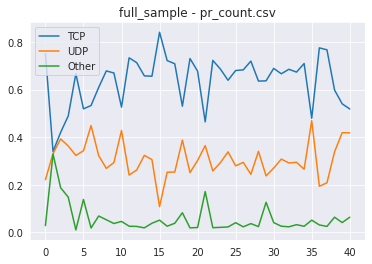

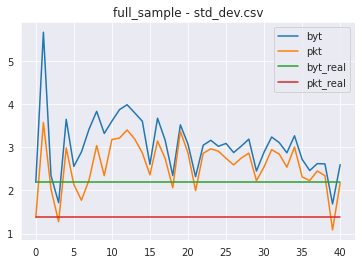

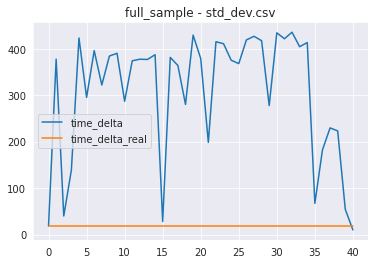

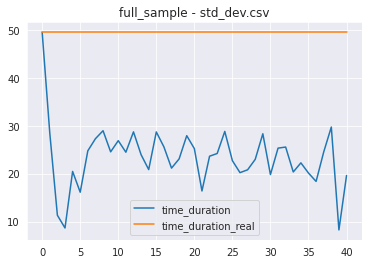

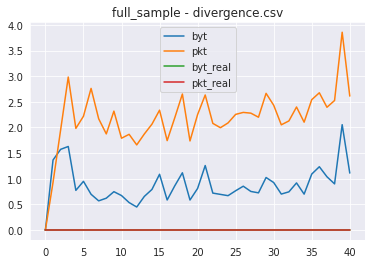

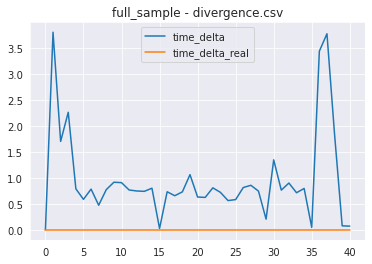

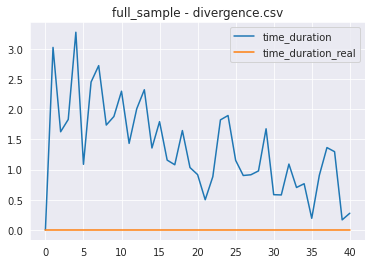

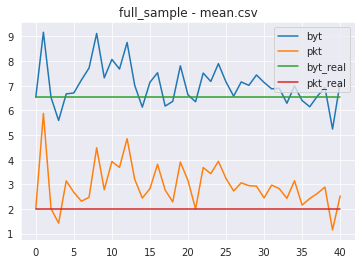

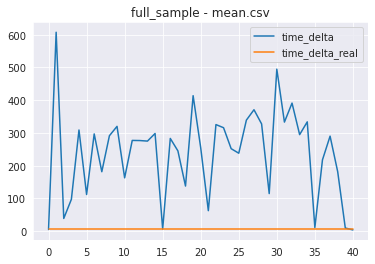

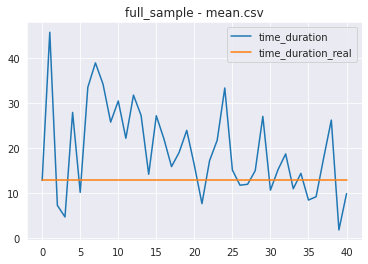

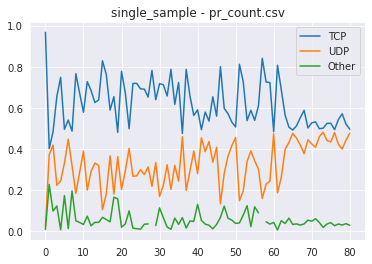

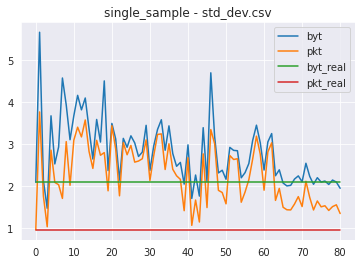

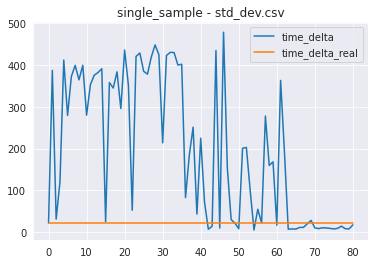

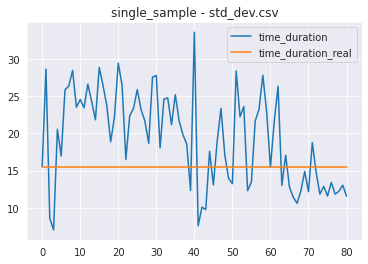

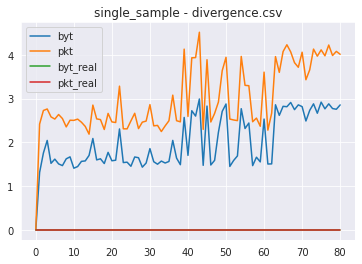

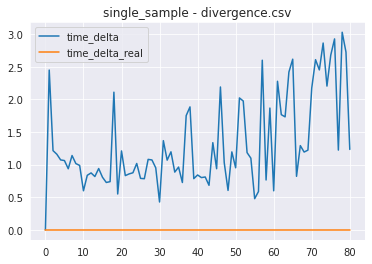

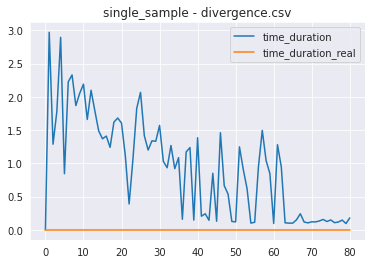

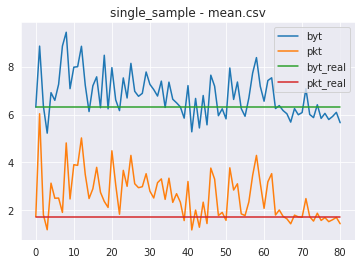

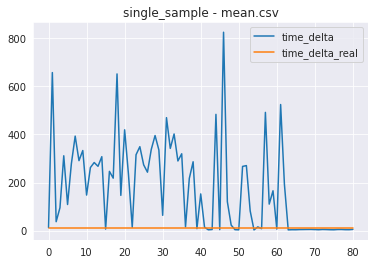

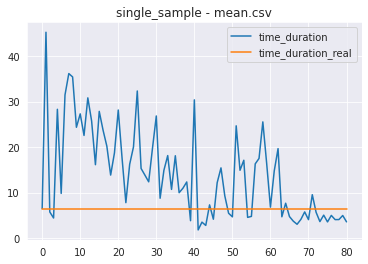

In [45]:
from os.path import split
#graph availble results
for f in glob.glob(rslt_path + '**/*.csv'):
    path, file = split(f)
    path, batch = split(path)

    stat = file.split('.')[0]
    df = pd.read_csv(f)

    Path(grph_rslt_path + '%s/' % batch).mkdir(parents=True, exist_ok=True)

    if file == 'pr_count.csv':
        df = df[['0', '1', '2']].div(df[['0', '1', '2']].sum(axis=1), axis=0)
        df.rename(columns={'0': 'TCP', '1': 'UDP', '2': 'Other'}, inplace=True)

        df.plot(title=batch + ' - ' + file).get_figure().savefig(grph_rslt_path + '%s/%s.png' % (batch, stat))
    else:
        df['byt_real'] = df.apply(lambda x: df.iloc[0]['byt'], axis=1)
        df['pkt_real'] = df.apply(lambda x: df.iloc[0]['pkt'], axis=1)
        df['time_delta_real'] = df.apply(lambda x: df.iloc[0]['time_delta'], axis=1)
        df['time_duration_real'] = df.apply(lambda x: df.iloc[0]['time_duration'], axis=1)

        display(df)

        df[['byt', 'pkt', 'byt_real', 'pkt_real']].plot(title=batch + ' - ' + file).set(ylabel='log(count)').get_figure().savefig(
            grph_rslt_path + '%s/%s_byt_pkt.png' % (batch, stat))
        df[['time_delta', 'time_delta_real']].plot(title=batch + ' - ' + file).get_figure().savefig(
            grph_rslt_path + '%s/%s_time_delta.png' % (batch, stat))
        df[['time_duration', 'time_duration_real']].plot(title=batch + ' - ' + file).get_figure().savefig(
            grph_rslt_path + '%s/%s_time_duration.png' % (batch, stat))




In [41]:
 #run rule checking on single samples
from stannetflow.evaluation import rule_check_runner

synth_window = Window.orderBy("order").rangeBetween(Window.unboundedPreceding, 0)

df_d1_test = pd.read_csv(part_path_day1 + 'local_ip=42.219.145.151/part-00003-34579832-af80-4406-a6e0-a1a82778d731.c000.csv',
                         index_col=False)
df_d1_test = df_d1_test[['byt', 'pkt', 'td', 'sa', 'da', 'sp', 'dp', 'pr']]
df_d1_test = df_d1_test.astype(rules_data_types)

for index, row in df_d1_test.iterrows():
    rule_check_runner.checkOneIPIntern(row['sa'], row['da'])
    rule_check_runner.checkPort80TCP(row['pr'], row['sp'], row['dp'])
    rule_check_runner.checkPort53UDP(row['pr'], row['sp'], row['dp'])
    rule_check_runner.checkRelationBytePackets(row['byt'], row['pkt'])

    rule_check_runner.checkDurationOnePacket(row['td'], row['pkt'])
    rule_check_runner.checkNetbios(row['sa'], row['da'], row['dp'], row['pr'])
    rule_check_runner.dsn21_check_ip(row['sa'], row['da'])


print(rule_check_runner.string_totals('UGR16'))
rule_check_runner.reset()

for epoch in range(0, 400, 5):

    df_sn_test = pd.read_csv(snth_path + 'epoch_%d/42.219.145.151.csv'%epoch, index_col=False)
    df_sn_test = df_sn_test.rename(columns={'time_duration':'td'})
    df_sn_test = df_sn_test[['byt', 'pkt', 'td', 'sa', 'da', 'sp', 'dp', 'pr']]
    df_sn_test = df_sn_test.astype(rules_data_types)

    rule_check_runner.reset()

    for index, row in df_sn_test.iterrows():
        rule_check_runner.checkOneIPIntern(row['sa'], row['da'])
        rule_check_runner.checkPort80TCP(row['pr'], row['sp'], row['dp'])
        rule_check_runner.checkPort53UDP(row['pr'], row['sp'], row['dp'])
        rule_check_runner.checkRelationBytePackets(row['byt'], row['pkt'])

        rule_check_runner.checkDurationOnePacket(row['td'], row['pkt'])
        rule_check_runner.checkNetbios(row['sa'], row['da'], row['dp'], row['pr'])
        rule_check_runner.dsn21_check_ip(row['sa'], row['da'])


    print(rule_check_runner.string_totals('epoch_%d'%epoch))
    rule_check_runner.reset()


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/Documents/data/stan/partitioned_data/day_1/without_attackslocal_ip=42.219.145.151/part-00003-34579832-af80-4406-a6e0-a1a82778d731.c000.csv'

In [32]:
#run classifier
from stannetflow.evaluation.task_model import nn_classifier
from stannetflow.synthesizers.stan import NetflowFormatTransformer
ntt = NetflowFormatTransformer
def encode_pr(pr):
    if pr == 'TCP':
        return 0
    elif pr == 'UDP':
        return 1
    else:
        return 2
#init model
classifier = nn_classifier.task1_classifier()

#read a data file
train = pd.read_csv(real_tst_day1_file, index_col=0)
train['sp_cont'] = train.apply(lambda r: r['sp'] / 65535, axis=1)
train['dp_cont'] = train.apply(lambda r: r['dp'] / 65535, axis=1)

#split protocol attribute from the rest
train_y = train.apply(lambda r: encode_pr(r['pr']), axis=1)
train_x = train[['log_byt', 'log_pkt', 'td', 'sp_cont', 'dp_cont']]


test = pd.read_csv(real_tst_day1_file)
test = test.drop('Unnamed: 0', axis=1) #drop mismatched index col
test['sp_cont'] = test.apply(lambda r: r['sp'] / 65535, axis=1)
test['dp_cont'] = test.apply(lambda r: r['dp'] / 65535, axis=1)


test_y = test.apply(lambda r: encode_pr(r['pr']), axis=1)
test_x = test[['log_byt', 'log_pkt', 'td', 'sp_cont', 'dp_cont']]

display(test_x)

classifier.scale(train_x, test_x)
classifier.fit(train_x, train_y)

model_out = classifier.predict(test_x)
prediction = model_out.tolist()

,log_byt,log_pkt,td,sp_cont,dp_cont
0,5.805135,1.609438,0.060,0.001678,0.552026
1,5.613128,1.609438,0.060,0.552026,0.001678
2,5.805135,1.609438,0.268,0.001678,0.831891
3,5.869297,1.945910,0.384,0.831891,0.001678
4,6.089045,0.000000,0.000,0.079118,0.077424
...,...,...,...,...,...
1711737,5.411646,1.609438,6.420,0.862409,0.013565
1711738,5.411646,1.609438,6.440,0.862394,0.013565
1711739,5.676754,1.386294,2.992,0.532860,0.002457
1711740,6.406880,1.791759,17.004,0.000000,0.011765


0 tensor(1.0393, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.0237, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.0078, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.9922, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.9779, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.9653, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.9517, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.9402, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.9269, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.9165, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.9079, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.8969, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.8864, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.8752, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.8678, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(0.8564, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor

{0: 1157362, 1: 109631, 2: 7436}

<AxesSubplot:ylabel='Count'>

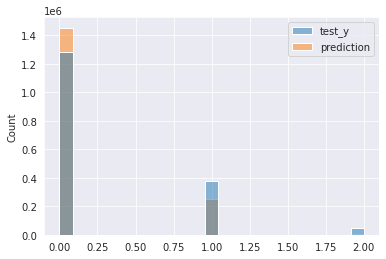

In [50]:

comparison = pd.DataFrame({'test_y':test_y,'prediction':prediction})
comparison.to_csv(rslt_path + 'classifier/predictions.csv')

match_dict = {0:0, 1:0, 2:0}

for index, r in comparison.iterrows():
    if r['test_y'] == r['prediction']:
        match_dict[r['test_y']] += 1

display(match_dict)
sns.histplot(data=comparison)

#fit the to train the mode175

In [ ]:
#run regressor
from stannetflow.evaluation.task_model import nn_regressor
from stannetflow.synthesizers.stan import NetflowFormatTransformer

train = pd.read_csv(real_tst_day1_file, index_col=0)


test = pd.read_csv(real_tst_day1_file)
test = test.drop('Unnamed: 0', axis=1) #drop mismatched index col